In [10]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import skimage as ski
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB

## Data Handling

In [11]:
cifar = tf.keras.datasets.cifar10.load_data()
(x_train, y_train), (x_test, y_test) = cifar

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship','truck']

In [12]:
# Taking a number of data points from each class
def get_N_from_each_class(N, percentage_of_testing_data, x_train, y_train, x_test, y_test):
    # Generating indices for the data points we are going to take from the data (both test and train)
    selected_indices = []
    for class_label in range(10):
        # For every possible index, take the index iff the point belongs to this class 
        class_indices = [i for i in range(len(y_train)) if y_train[i][0] == class_label]
        selected_indices.append(class_indices[:N])

    # Picking the data based on the indices
    x_train = x_train[selected_indices]
    y_train = y_train[selected_indices]
    # Reshaping the data to flatten it to all classes together (to get it back to original form)
    x_train = x_train.reshape(-1, 32, 32, 3)
    y_train = y_train.reshape(-1, 1)

    # Doing the same with the test data
    selected_indices = []
    for class_label in range(10):
        class_indices = [i for i in range(len(y_test)) if y_test[i][0] == class_label]
        selected_indices.append(class_indices[:int(N * percentage_of_testing_data)])

    x_test = x_test[selected_indices]
    y_test = y_test[selected_indices]
    x_test = x_test.reshape(-1, 32, 32, 3)
    y_test = y_test.reshape(-1, 1)

    # Randomizing data, just in case
    # np.random.shuffle(x_train)
    # np.random.shuffle(y_train)
    # np.random.shuffle(x_test)
    # np.random.shuffle(y_test)

    indices = np.random.permutation(len(x_train))
    x_train = x_train[indices]
    y_train = y_train[indices]

    indices = np.random.permutation(len(x_test))
    x_test = x_test[indices]
    y_test = y_test[indices]

    return (x_train, y_train), (x_test, y_test)


n_samples_from_each_class = 3000
(x_train, y_train), (x_test, y_test) = get_N_from_each_class(n_samples_from_each_class, 0.3, x_train, y_train, x_test, y_test)

In [13]:
# extrating the features from the images
# method used: Central Moments

def extract_image_features(image, C=3):
    '''
    Extracts the features from the image using the central moments method of order C
    It turns the image to grayscale, then calculates the central moments of order C
    
    Parameters:
    image: the image to be processed
    C: the moments order

    Returns:
    features: a vector of the features extracted from the image
    '''

    # turning the image to grayscale
    image = ski.color.rgb2gray(image)

    # calculating the central moments
    cal_moments = ski.measure.moments_central(image, order=C)

    # create an np array that contains zeroes 
    features = np.zeros(shape=int((C + 1) * (C + 2) / 2))

    # turn the 2D array to 1D by putting only the needed values based on this equation 
    # p + q <= C 
    # if C = 3 the needed numbers are : 00 01 10 11 20 02 21 12 03 30 , size = 10 s
    current = 0;
    for i in range(C + 1):
        for j in range(C + 1):
            if i + j <= C:
                features[current] = cal_moments[i][j]
                current = current + 1

    return features

In [14]:
from sklearn.preprocessing import StandardScaler

C_order = 5
# Extracting the images features
Training_features = np.array([extract_image_features(x_train[i], C_order) for i in range(len(x_train))])
Testing_features = np.array([extract_image_features(x_test[i], C_order) for i in range(len(x_test))])

# Fit the scaler on training data
scaler = StandardScaler().fit(Training_features)

# Standardize both training and testing data
standardized_training_features = scaler.transform(Training_features)
standardized_test_features = scaler.transform(Testing_features)

In [15]:
# Note that gaussian has no hyperparameters so we could try none
gaussianNB = GaussianNB()

# Training
gaussianNB.fit(standardized_training_features, y_train.flatten())

# Prediction
y_predict = gaussianNB.predict(standardized_test_features)

# Calculating Metrics
gaussian_accuracy = accuracy_score(y_test, y_predict)
gaussian_precision = precision_score(y_test, y_predict, average='macro')
gaussian_recall = recall_score(y_test, y_predict, average='macro')
gaussian_f1 = f1_score(y_test, y_predict, average='macro')


print("Gaussian Naive Bayes Accuracy: ", gaussian_accuracy)
print("Gaussian Naive Bayes Precision: ", gaussian_precision)
print("Gaussian Naive Bayes Recall: ", gaussian_recall)
print("Gaussian Naive Bayes F1 Score: ", gaussian_f1)


Gaussian Naive Bayes Accuracy:  0.22455555555555556
Gaussian Naive Bayes Precision:  0.22590081480408752
Gaussian Naive Bayes Recall:  0.22455555555555554
Gaussian Naive Bayes F1 Score:  0.19851436393015415


Correct Examples: 2
Incorrect Examples: 8


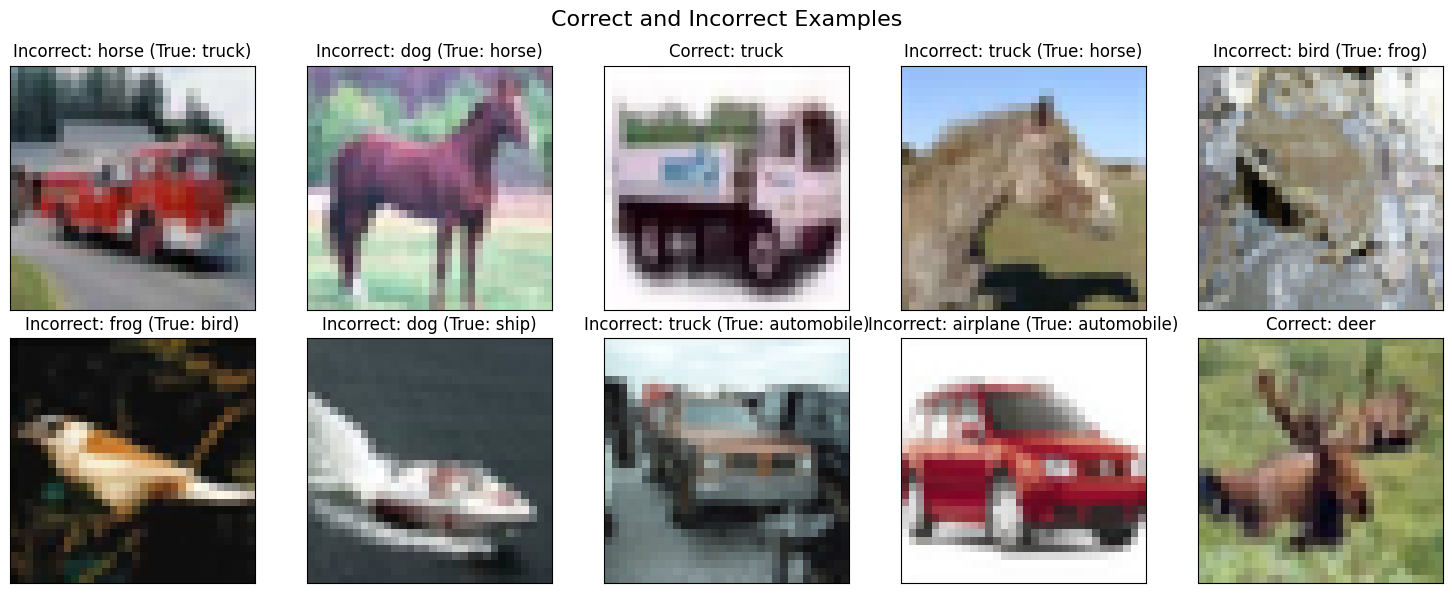

In [17]:
# Create a figure with subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Correct and Incorrect Examples', fontsize=16)

# Initialize counters for correct and incorrect examples
correct_count = 0
incorrect_count = 0

# Iterate over the predicted labels and compare with true labels
for i, ax in enumerate(axes.flat):
    # Get the predicted and true labels for the current example
    predicted_label = y_predict[i]
    true_label = y_test[i]

    # Check if the prediction is correct
    if predicted_label == true_label:
        # Plot the correct example
        ax.imshow(x_test[i])
        ax.set_title(f'Correct: {labels[int(predicted_label)]}')
        correct_count += 1
    else:
        # Plot the incorrect example
        ax.imshow(x_test[i])
        ax.set_title(f'Incorrect: {labels[int(predicted_label)]} (True: {labels[int(true_label)]})')
        incorrect_count += 1

    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust spacing between subplots
plt.tight_layout()

# Print the count of correct and incorrect examples
print(f'Correct Examples: {correct_count}')
print(f'Incorrect Examples: {incorrect_count}')
